### Importing necessary packages

In [0]:
# training and testing if made on google colaboratory
from google.colab import drive

drive.mount('/content/drive')

!pip3 install torch torchvision

In [0]:
!git clone https://github.com/SeanNaren/warp-ctc.git
%cd warp-ctc
!mkdir build
%cd build
!cmake ..
!make

In [0]:
%cd ../pytorch_binding/
!python setup.py install

In [0]:
# necessary imports
import os
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import cv2

from collections import OrderedDict
from pydub import AudioSegment
from scipy import signal
from PIL import Image
from torch import autograd
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset

from warpctc_pytorch import CTCLoss

### Loading data

In [0]:
# root path if remote
root_path = '/content/drive/My Drive/speech_recogniser/'

In [0]:
# root path if local
root_path = './'

In [0]:
data_dir = root_path + 'data/'
model_dir = root_path + "models/"

train_dir = data_dir + 'train'
test_dir = data_dir + 'test'
valid_dir = data_dir + 'valid'

In [0]:
# helper function to resolve a file transcription
def resolve_transcription(files, transcription, relative_path = "./"):
    # our transcriptions
    transcriptions = []
    
    with open(relative_path + transcription, "r") as trans_file:
        # looping through each line from transcription
        for line in trans_file:
            # perform a single split, first match - audio source, second match - targets(text)
            match = line.split(" ", 1)
            
            # expecting two elements and filter out long seq
            if(len(match) == 2):
                
                # our audio source with full name
                audio_source = match[0] + ".flac"

                # expecting the audio source to be present
                if(audio_source not in files):
                    pass

                # append to our transcriptions
                transcriptions.append({
                    "targets" : match[1][:-1],
                    "audio" : relative_path + audio_source,
                    "image" : relative_path + match[0] + ".png"
                })
                    
    return transcriptions    

# helper function to retrieve the paths
def resolve_data(dir_path):
    dirs = os.listdir(dir_path)

    transcriptions = []
    
    for directory in dirs:
        for sub_dir in os.listdir(dir_path + "/" + directory):
            # current directory
            curr_dir = dir_path + "/" + directory + "/" + sub_dir + "/"
            
            # files including images, audio files and text
            files = os.listdir(curr_dir)
            
            # filtering files by text
            files_text = [ file for file in files if file.endswith(".txt") ]
            
            # only one single transcription per directory source
            if(len(files_text) == 1):
                # our transcription to be resolved(link between the actual text and the audio source and image if exists)
                transcription = files_text[0]
                
                # resolved transcription with audio source and spectrogram(image path)
                resolved_transcription = resolve_transcription(files, transcription, relative_path = curr_dir)
                
                # concatenate with our raw list
                transcriptions += resolved_transcription

    return transcriptions

In [0]:
# data types
data_types = {"train" : train_dir, "valid" : valid_dir, "test" : test_dir}

# transcriptions holder
transcriptions = {data_type : resolve_data(data_dir) for data_type, data_dir in data_types.items()}

In [0]:
# default sampling rate
sampling_rate = 16000

# sampling chunk length
nfft = 200

# sampling length to be padded
sampling_pad = sampling_rate / nfft

# helper function to resolve an audio source file to spectrogram
def resolve_image_source(transcription, rewrite = False, interactive = False, dpi = 101):
    # image source
    image_source = transcription["image"]
    
    # rewrite turned off and image source exists then show only
    image_save = not (not rewrite and os.path.isfile(image_source))
    
    # if not interactive and no rewriting is required then finish
    if(not (image_save or interactive)):
        return
    
    # audio source
    audio_source = transcription["audio"]
    
    if(audio_source.endswith((".flac", ".wav"))):
        raw = AudioSegment.from_file(audio_source)
    else: 
        raw = AudioSegment.from_mp3(audio_source)

    # single channel
    raw = raw.set_channels(1)
    
    # downsampling the audio source
    # raw = raw.set_frame_rate(sampling_rate)

    # retrieving data
    data = raw.get_array_of_samples()
    
    # data to numpy array
    data = np.array(data)
    
    # sample frequencies, segment times, frequencies domain output where nfft 200 => 16000 / 200 = 80 => 12.5ms chunk
    f, t, Sxx = signal.spectrogram(data, raw.frame_rate, nfft = nfft, nperseg = nfft, noverlap = 0)
    
    # dimensions
    row, col = Sxx.shape[0], Sxx.shape[1]

    # normalizing dimensions
    row, col = 1.0, (col / row)
    
    # dpi to match the file size
    fig = plt.figure(figsize = (col, row), dpi = dpi)
    fig.subplots_adjust(0, 0, 1, 1)

    plt.set_cmap("gray")
    
    ax = fig.add_subplot(1, 1, 1, frameon = False)
    ax.pcolormesh(t, f, 10 * np.log10(Sxx + 0.000001))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    if(image_save):
        plt.savefig(image_source)
    
    # don't show figure if not interactive
    if(not interactive):
        plt.close(fig)

# helper function to clean the generated spectrogram
def clean_image_source(transcription):
    # image source
    image_source = transcription["image"]
    
    # check if image source exists
    if(os.path.isfile(image_source) and not os.path.isdir(image_source)):
        os.remove(image_source)
        
# helper function to resolve all audio sources file to spectrograms
def resolve_transcription_images(transcriptions, rewrite = True, clean = False):
    
    # interactive mode turned off
    plt.ioff()
    
    for transcription in transcriptions:
        
        # clean all
        if(clean):
            clean_image_source(transcription)
            
        resolve_image_source(transcription, rewrite, interactive = False)
        
    # interactive mode turned on for default behaviour
    plt.ion()

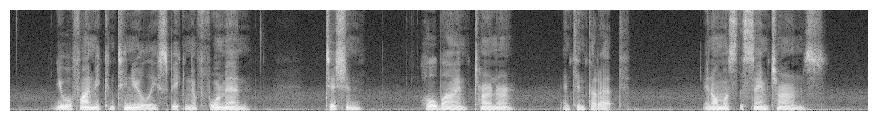

In [11]:
resolve_image_source(transcriptions["train"][0], rewrite = False, interactive = True)

Generating for each audio source and image representing the spectrogram related to the audio source

In [0]:
for key, value in transcriptions.items():
    resolve_transcription_images(transcriptions[key], rewrite = False)

#### Finding the normalization parameters and adjusting the data accordingly

Padding uneven images with black color

In [0]:
# helper function to resolve the maximum dimensions in order to pad properly
def resolve_dimensions(transcriptions):
    # max width, height
    width, height = 0, 0
    
    for transcription in transcriptions:
        # open the image
        img = Image.open(transcription["image"])
        
        # current width and height of the image
        img_width, img_height = img.size
        
        # take the max
        width, height = max(width, img_width), max(height, img_height)
        
    return (width, height)

In [14]:
width_max, height_max = resolve_dimensions(transcriptions["test"])

print("Width: {}px, Height: {}px".format(width_max, height_max))

Width: 2796px, Height: 101px


In [0]:
# helper function to generate image source, single channel image to be assumed
def generate_image_source(img = None, transcription_path = None):
    
    if(transcription_path is None and img is None):
        raise Exception("Illegal arguments provided")
    
    if(transcription_path is not None):
        
        # get the image source
        img = Image.open(transcription_path)
        
    return np.array(img, dtype = 'float64')[:, :, 0] / 255.0

def per_sample(sample, mean):
    # flatten the array
    sample = sample.flatten()
        
    return ((sample - mean) ** 2).sum(), len(sample)

def generate_data_transforms(transcriptions):
    # mean and std
    mean, std = 0, 0
    
    # calculating mean of images
    for transcription in transcriptions:
        
        # acc the mean(_, _, 3)
        mean += generate_image_source(transcription_path = transcription["image"]).mean()
        
    # our mean
    mean = mean / len(transcriptions)
    
    # pixels count
    count = 0
    
    for transcription in transcriptions:
        sampl = per_sample(generate_image_source(transcription_path = transcription["image"]), mean)
        
        std += sampl[0]
        count += sampl[1]

    return mean, (std / count) ** (1 / 2)

In [0]:
# data transforms
trans_mean, trans_std = generate_data_transforms(transcriptions["train"])

In [17]:
print("Images: mean - {}, std - {}".format(trans_mean, trans_std))

Images: mean - 0.48091523445303713, std - 0.17174699123997303


In [0]:
# helper function to pad an image with black color the extended area
def resolve_image_pad(transcription, dimensions):
    
    # open the image
    img = Image.open(transcription["image"])

    # retrieving the original size
    transcription["features_size"] = img.size

    # create a new image with size padded
    img_new = Image.new("RGB", dimensions)

    # past the image from top-left, given they have same height
    img_new.paste(img)

    return (generate_image_source(img = img_new) - trans_mean) / trans_std

In [0]:
def resolve_text_dict(ch, t, dic = None):    
    if(dic is not None and ch not in dic):
        dic.add(ch)
        
    t.append(ch)

# helper function to filter a text transcription
def resolve_transcription_filter(transcription, dic = None):
    # our new transcription
    t = []
    
    for ch in transcription:
        # ascii value
        a = ord(ch)
        
        if(a >= 65 and a <= 90):
            resolve_text_dict(a + 32, t, dic)
        elif((a >= 97 and a <= 122) or a == 32 or a == 39):
            resolve_text_dict(a, t, dic)
            
    return t

# helper function to resolve transcriptions text to filtered unique integer sequences
def resolve_transcriptions_text(transcriptions, character_max = None, character_to_int = None, int_to_character = None, character_set = None):
    
    seen_data = character_max is None and character_to_int is None
    
    if(seen_data):
        # our set with unique characters
        character_set = set()

        # max characters
        character_max = 0

    for transcription in transcriptions:

        # filtered transcription
        transcription["targets_filtered"] = resolve_transcription_filter(transcription["targets"], character_set)

        if(seen_data):
            # get max sequence length for padding
            character_max = max(character_max, len(transcription["targets"]))

    if(seen_data):
        # mapping dict from normalized ints to ascii(character); +1 as the 0 is label protected(CTCLoss)
        int_to_character = { index + 1 : ch for index, ch in enumerate(list(character_set)) }

        # mapping from ascii(character) to normalized ints
        character_to_int = { ch : index for index, ch in int_to_character.items() }
    
    for transcription in transcriptions:
        # original size before padding
        transcription["targets_size"] = len(transcription["targets"])
        
        # padding length to be appended
        padding_len = character_max - transcription["targets_size"]
        
        # ascii to normalized ints
        transcription["targets_filtered"] = [ character_to_int[ch] for ch in transcription["targets_filtered"] ] + [0] * padding_len
        
        
    return character_to_int, int_to_character, character_max

In [0]:
character_to_int, int_to_character, character_max = resolve_transcriptions_text(transcriptions["train"])

resolve_transcriptions_text(transcriptions["valid"], character_max, character_to_int)

Generating the data loaders for training and validating the model

In [0]:
# our batch size
batch_size = 32

def generate_dataloader(transcriptions):
    
    # our empty data
    features, features_size, targets, targets_size = [], [], [], []
    
    # dataset used as input to data loader
    for t in transcriptions:
        
        # normalizing features
        features.append(resolve_image_pad(t, dimensions = (width_max, height_max)))
        
        # take the width, while height is static
        features_size.append(t["features_size"][0])
        
        targets.append(t["targets_filtered"])
        
        targets_size.append(t["targets_size"])
        
    # clipping size
    clipping_size = (len(features) // batch_size) * batch_size
        
    # to numpy
    features, features_size, targets, targets_size = np.array(features[:clipping_size], dtype = 'float32'),\
        np.array(features_size[:clipping_size]), np.array(targets[:clipping_size]), np.array(targets_size[:clipping_size])
    
    # tensor dataset
    tensor_dataset = TensorDataset(torch.from_numpy(features), torch.from_numpy(targets),\
        torch.from_numpy(features_size), torch.from_numpy(targets_size))
    
    return DataLoader(tensor_dataset, batch_size = batch_size, shuffle = True)

In [0]:
train_loader = generate_dataloader(transcriptions["train"])
valid_loader = generate_dataloader(transcriptions["valid"])

Device where the training process will be done, either on cpu or gpu if cuda is available.

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


# Building and training the classifier

Building the classifier.

In [0]:
class Network(nn.Module):
    def __init__(self, num_layers, hidden_size, output_size):
        super(Network, self).__init__()
        ''' Init the layers to be used '''
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.sec1 = nn.Sequential(
            # conv1 => 1 x 101
            nn.Conv2d(1, 8, 5, padding = 2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            # pool1 => 1 x 51
            nn.MaxPool2d((3, 1), stride = (2, 1), padding = (1, 0))
        )
        
        self.sec2 = nn.Sequential(
            # conv2 => 1 x 51
            nn.Conv2d(8, 16, 3, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # pool2 => 1 x 26
            nn.MaxPool2d((3, 1), stride = (2, 1), padding = (1, 0))
        )
        
        self.sec3 = nn.Sequential(
            # conv3 => 1 x 26
            nn.Conv2d(16, 32, 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # pool3 => 1 x 13
            nn.MaxPool2d((3, 1), stride = (2, 1), padding = (1, 0))
        )
        
        # gru layer 32 x 13 => 416
        self.gru = nn.GRU(input_size = 416, hidden_size = self.hidden_size, num_layers = self.num_layers, batch_first = True)
        
        # dropout layer
        self.drp1 = nn.Dropout(0.2)
        
        # fully connected layer
        self.fc1 = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x, hidden):
        ''' Forward implementation '''
        
        # joining batches with features segments
        x.view(-1, 1, 1, 101)
        
        # 1st layer
        x = self.sec1(x)
        
        # 2nd layer
        x = self.sec2(x)
        
        # 3rd layer
        x = self.sec3(x)
        
        # gru pass; first batch size 
        x, hidden = self.gru(x.view(batch_size, -1, 416), hidden)
        
        # stacking the gru layers 
        x = x.contiguous().view(-1, self.hidden_size)
       
        x = F.relu(self.fc1(self.drp1(x)))
        
        return F.log_softmax(x.view(batch_size, -1, self.output_size), dim = 2), hidden
    
    
    def init_hidden(self):
        ''' Initializes hidden state '''
        # get an instance of data with same type and structure
        weight = next(self.parameters()).data
        
        # create a new tensor by copying and setting to zero
        hidden = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)

        return hidden

In [25]:
# vocabulary size, characters allowed and available
vocabulary_size = len(character_to_int)

print(vocabulary_size)

28


In [0]:
# hidden size
hidden_size = 512

# num layers
num_layers = 2

# model
model = Network(num_layers = num_layers, hidden_size = hidden_size, output_size = vocabulary_size)

# move to corresponding available device
model = model.to(device)

### Defining hyperparameters

In [0]:
# learning rate
learning_rate = 0.0001

# loss function, reduction mean instead of sum as the padded-zone is not considered
criterion = CTCLoss(length_average = True)

# optimizer
optimizer = optim.Adadelta(model.parameters(), lr = learning_rate)

### Training the network(feature extractors & classifier)

In [0]:
def train_model(epochs = 20, valid_loss_min = None):
    
    # check if none, if not use the saved valid_loss_min
    if(valid_loss_min is None):
        valid_loss_min = np.inf
    
    for epoch in range(epochs):

        # validation constraints
        train_acc_loss, valid_acc_loss = 0, 0

        # training mode
        model.train()

        for features, targets, features_size, targets_size in train_loader:
            
            # our hidden layer
            hidden = model.init_hidden()

            # removing accumulated gradients
            optimizer.zero_grad()

            # moving features and labels to the corresponding available device
            features, targets, features_size, targets_size = features.to(device), targets.to(device), features_size.to(device), targets_size.to(device)

            # pass forward done, by adding one more dimension to the tensor for color channel(grey)
            outputs, hidden = model(features.unsqueeze(1), hidden)
            
            # calculating loss
            loss = criterion(outputs.view(-1, batch_size, vocabulary_size).cpu(), targets.view(-1).int().cpu(), features_size.int().cpu(), targets_size.int().cpu())
            
            print(loss.item())

            # calculating gradient
            loss.backward()

            # adjusting weights
            optimizer.step()
           
            train_acc_loss += loss.item()

        # evaluation mode
        model.eval()

        with torch.no_grad():
            for features, targets, features_size, targets_size in valid_loader:
                
                # our hidden layer
                hidden = model.init_hidden()

                # moving features and labels to the corresponding available device
                features, targets, features_size, targets_size = features.to(device), targets.to(device), features_size.to(device), targets_size.to(device)

                # pass forward done
                outputs, hidden = model(features.unsqueeze(1), hidden)
                
                # calculating loss
                loss = criterion(outputs.view(-1, batch_size, vocabulary_size).cpu(), targets.view(-1).int().cpu(), features_size.int().cpu(), targets_size.int().cpu())

                # acc validation loss
                valid_acc_loss += loss.item()

        # average losses calculation
        train_acc_loss = train_acc_loss / len(train_loader.dataset)
        valid_acc_loss = valid_acc_loss / len(valid_loader.dataset)

        # print training / validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch + 1, train_acc_loss, valid_acc_loss))

        if(valid_acc_loss <= valid_loss_min):
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_acc_loss))

            torch.save(model.state_dict(), model_dir + 'model_speech_recogniser.pt')

            valid_loss_min = valid_acc_loss
            
    return valid_loss_min
            
# training model
valid_loss_min = train_model(20)

### Save the checkpoint

In [0]:
# save the checkpoint
checkpoint = {
    'input_size': [1, width_max, height_max],
    'batch_size': batch_size,
    'trans_state' : {
        'trans_mean' : trans_mean,
        'trans_std' : trans_std
    },
    'output_size': vocabulary_size,
    'valid_loss_min' : valid_loss_min,
    'state_dict': torch.load(model_dir + 'model_speech_recogniser.pt')
}

torch.save(checkpoint, model_dir + 'model_speech_recogniser.pt')

### Loading the checkpoint

In [0]:
# loading a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    # loading checkpoint
    checkpoint = torch.load(filepath, map_location = 'cpu')
    
    # saved model
    model = Network(num_layers = 2, hidden_size = 256, output_size = vocabulary_size)

    # move to corresponding available device
    model = model.to(device)
    
    # loading the state(trained weights)
    model.load_state_dict(checkpoint['state_dict'])
    
    return (model, checkpoint['valid_loss_min'], *checkpoint['trans_state'])

model, valid_loss_min, trans_mean, trans_std = load_checkpoint(model_dir + 'model_speech_recogniser.pt')